In [1]:
import numpy as np
import xarray as xr
import rfmtools
import matplotlib.pyplot as plt

In [2]:
heights = rfmtools.make_grid._get_height_array(dz=1000)

In [3]:
temp, h2o, pres = rfmtools.make_grid._get_temp_h2o_pres_from_height(height_array=heights, Ts=300, Tstrat=200)

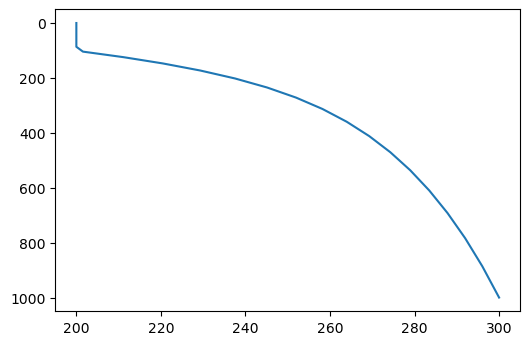

In [4]:
plt.figure(dpi=100)
plt.plot(temp, pres)
plt.gca().invert_yaxis()

In [5]:
rfmtools.make_input_files.generate_atm_file(fname='fulltest_dz1km.atm', height=heights/1000, temp=temp, h2o=h2o, pres=pres, co2=288)

In [6]:
rfmtools.make_input_files.make_driver(
    runtype='radiance',
    fname='rfm.drv', 
    atmfile='fulltest_dz1km.atm', 
    SPC="0.1 1500 0.1",
    GAS="CO2",
    HIT=rfmtools.utils.RFM_DIR+"/hit/hitran_2016.bin")

In [7]:
rfmtools.utils.RFM_DIR

'/gws/nopw/j04/aopp/andreww/side_projects/RFM'

In [8]:
da = rfmtools.run.run(drv_file=rfmtools.utils.RFM_DIR+"/src/rfm.drv")
da

Running RFM...
RFM run successful!


<xarray.DataArray (wavenumber: 15000)>
array([7.73175799e-08, 3.09268358e-07, 6.95846381e-07, ...,
       9.49860513e-02, 9.49594602e-02, 9.49328691e-02])
Coordinates:
  * wavenumber  (wavenumber) float64 0.1 0.2 0.3 0.4 ... 1.5e+03 1.5e+03 1.5e+03

Text(0, 0.5, 'Radiance [W/m2/cm-1]')

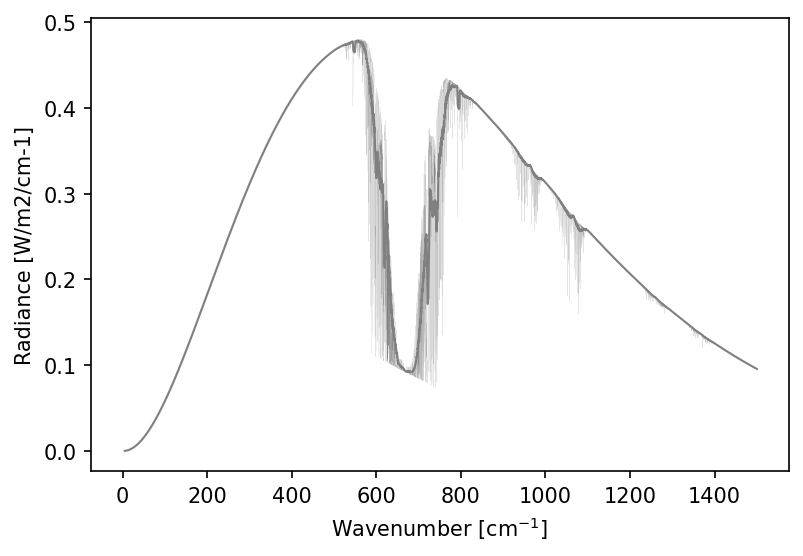

In [9]:
fig, ax = plt.subplots(dpi=150)

da.plot(ax=ax, lw=0.05, color='black', alpha=0.5)
da.rolling(wavenumber=50).mean().plot(ax=ax, lw=1, color='grey')
ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('Radiance [W/m2/cm-1]')

In [10]:
def planck_wavenumber(nu,T):
    """
    Returns in W/m2/m
    """
    import scipy.constants
    h = scipy.constants.h
    pi = scipy.constants.pi
    c = scipy.constants.c
    kb = scipy.constants.Boltzmann
    u = h*nu/(kb*T)
    return 2.*pi*(kb*T)**3/((h*c)**2) * u**3/(np.exp(u)-1.)


def planck_nu(n,T,unit="cm^-1"):
    """
    Based on Ray's book.
    NOTE: Returns the radiance in W/m2/[length]
    where [length] is the unit in which I'm measuring the spectral axis.

    Conversion factor 'k' is necessary because Planck_wavenumber (above) returns
    """
    import scipy.constants
    h = scipy.constants.h
    c = scipy.constants.c
    kb = scipy.constants.Boltzmann
    if unit=="m^-1":
        k = 1.
    elif unit=="cm^-1":
        n = n*100.
        k = 100.
    else:
        print( "(planck_nu) Error: unit not recognized!")
    return k*c*planck_wavenumber(n*c,T)

Text(0, 0.5, 'Radiance [W/m2/cm-1]')

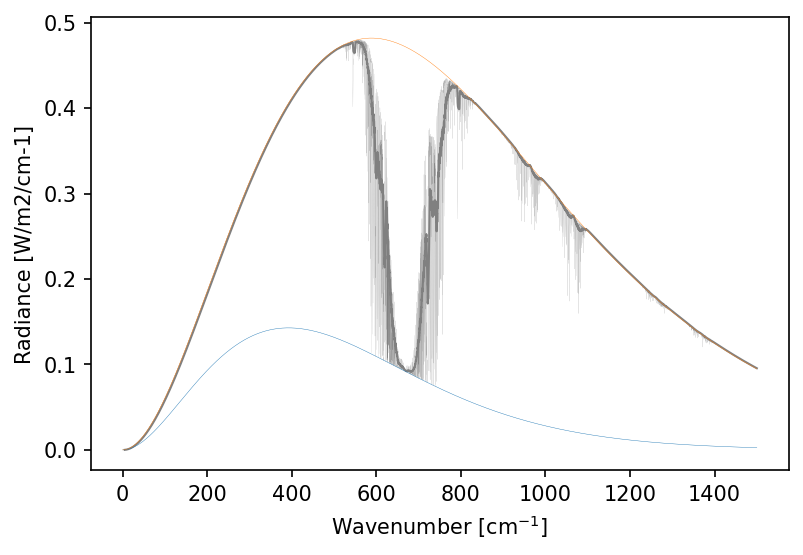

In [11]:
fig, ax = plt.subplots(dpi=150)

da.plot(ax=ax, lw=0.05, color='black', alpha=0.5)
da.rolling(wavenumber=50).mean().plot(ax=ax, lw=1, color='grey')

ax.plot(da.wavenumber, planck_nu(n=da.wavenumber, T=200, unit='cm^-1'), lw=0.2)
ax.plot(da.wavenumber, planck_nu(n=da.wavenumber, T=300, unit='cm^-1'), lw=0.2)

ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('Radiance [W/m2/cm-1]')

# Wrap into a function

In [12]:
def get_olr(Ts=300, Tstrat=200, co2=288, spec_range="0.1 1500 0.1", gases="CO2 H2O", clean_files=True):
    heights = rfmtools.make_grid._get_height_array(dz=200)
    temp, h2o, pres = rfmtools.make_grid._get_temp_h2o_pres_from_height(height_array=heights, Ts=Ts, Tstrat=Tstrat)
    
    # Make atm file
    rfmtools.make_input_files.generate_atm_file(fname='fulltest_dz200m.atm', height=heights/1000, temp=temp, h2o=h2o, pres=pres, co2=co2)
    
    # Make driver
    rfmtools.make_input_files.make_driver(
    runtype='radiance',
    fname='rfm.drv', 
    atmfile='fulltest_dz200m.atm', 
    SPC=spec_range,
    GAS=gases,
    HIT=rfmtools.utils.RFM_DIR+"/hit/hitran_2016.bin")
    
    da = rfmtools.run.run(drv_file=rfmtools.utils.RFM_DIR+"/src/rfm.drv", clean_files=clean_files)
    return da.integrate(dim='wavenumber')

In [ ]:
%%time

TEMPS = np.linspace(280, 320, 41)
CO2_arr = np.zeros(len(TEMPS))

# baseline OLR0
OLR0 = get_olr(Ts=288,co2=280)


co2_init = 1
for temp_idx,sst in enumerate(TEMPS):

    if temp_idx==0:
        co2_trial=co2_init

    olr = get_olr(Ts=sst,co2=co2_trial)

    imbalance = (olr-OLR0).values
    
    print(f"Ts={sst}K")
    while np.abs(imbalance)>0.01:

        F2x=5
        co2_trial=co2_trial * np.power(2, imbalance/F2x) 
        
        olr = get_olr(Ts=sst,co2=co2_trial)

        imbalance = (olr-OLR0).values
        
    print(f"For Ts={sst}K, co2_final={co2_trial}, imbalance={imbalance}")
    CO2_arr[temp_idx] = co2_trial


Running RFM...


In [ ]:
C_Ts = xr.DataArray(CO2_arr, dims=['Ts'], 
                    coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'})},
                    attrs={'standard_name': 'CO$_{2}$', 'units': 'ppmv'})

Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                    coords={'CO2':xr.DataArray(CO2_arr, dims=['CO2'], attrs={'units':'ppmv'})},
                    attrs={'standard_name': 'Ts', 'units': 'K'})

fig,ax=plt.subplots(dpi=100)
C_Ts.plot(ax=ax, yscale='log', color='k')
ax.scatter(C_Ts.Ts, C_Ts, color='k', s=15)

In [ ]:
da_ECS = C_Ts.copy()
da_ECS.attrs = {'standard_name':'ECS', 'units': 'K'}

for temp in da_ECS.Ts:
    conc = C_Ts.sel(Ts=temp)
    da_ECS.loc[dict(Ts=temp)] = Ts_C.interp(CO2=2*conc) - Ts_C.sel(CO2=conc) 

In [ ]:
fig,axs=plt.subplots(ncols=2, figsize=(12,4), dpi=100)

C_Ts.plot(ax=axs[0], yscale='log', color='k')
axs[0].scatter(C_Ts.Ts, C_Ts, color='k', s=15)
axs[0].set_title(r"CO$_{2}$(T$_{s}$) curve")

da_ECS.plot(ax=axs[1], color='k')
axs[1].scatter(C_Ts.Ts, da_ECS, color='k', s=15)
axs[1].set_title(r"Inferred ECS")